In [5]:
%load_ext autoreload
%autoreload 2
from paths import create_predictions_path
import numpy as np
import pandas as pd

from ranking_helpers import CIVILCOMMENTS_GROUP_VARS, CAMELYON17_GROUP_VARS, get_model_accuracies_df
dataset = "civilcomments"
model = "distilbert-base-uncased"

# dataset = "camelyon17"
# model = "densenet121"
algs = ["ERM", "IRM", "GroupDRO", "CORAL"]
split = "test"

expt_config = {'dataset':  dataset,
               'model': model,
               'learning_algs': algs,}

# Values for each algorithm = whether the predicted label is correct.
results_df = get_model_values_df(expt_config, split=split, value='accuracy')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Mean accuracies across algorithms
results_df[algs].mean()

ERM         0.921574
IRM         0.881217
GroupDRO    0.902745
CORAL       0.882802
dtype: float64

In [8]:
# Groupings based on individual variable
## ERM dominates for individual groups for civilcomments
## Not true for camelyon17
if dataset == 'camelyon17':
    group_variables = CAMELYON17_GROUP_VARS
elif dataset == 'civilcomments':
    group_variables = CIVILCOMMENTS_GROUP_VARS

for group_var in group_variables:
    print(results_df.groupby(group_var)[algs].agg(['mean', 'count']))
    print()

               ERM               IRM          GroupDRO             CORAL  \
              mean   count      mean   count      mean   count      mean   
sex:male                                                                   
0         0.925322  119487  0.886866  119487  0.907136  119487  0.887569   
1         0.890241   14295  0.833998   14295  0.866037   14295  0.842952   

                  
           count  
sex:male          
0         119487  
1          14295  

                 ERM               IRM          GroupDRO             CORAL  \
                mean   count      mean   count      mean   count      mean   
sex:female                                                                   
0           0.924233  117333  0.886681  117333  0.906003  117333  0.886289   
1           0.902608   16449  0.842240   16449  0.879506   16449  0.857924   

                    
             count  
sex:female          
0           117333  
1            16449  

                        ER

In [9]:
# Combinations of group variables
# let's do sex and black race
aggregate_group_vars = ['sex:male', 'race:black', 'religion:muslim']

results_df['aggregate_group'] = results_df[aggregate_group_vars].apply(lambda x: tuple(x), axis=1)
results_df.groupby('aggregate_group')[algs].agg(['mean', 'count'])



ERM               IRM          GroupDRO          \
                     mean   count      mean   count      mean   count   
aggregate_group                                                         
(0, 0, 0)        0.935774  109130  0.898992  109130  0.918107  109130   
(0, 0, 1)        0.834178    6314  0.749287    6314  0.797751    6314   
(0, 1, 0)        0.789474    3857  0.778584    3857  0.784548    3857   
(0, 1, 1)        0.704301     186  0.688172     186  0.725806     186   
(1, 0, 0)        0.900491   13034  0.844637   13034  0.876170   13034   
(1, 0, 1)        0.784722     432  0.675926     432  0.750000     432   
(1, 1, 0)        0.786906     779  0.750963     779  0.771502     779   
(1, 1, 1)        0.740000      50  0.720000      50  0.700000      50   

                    CORAL          
                     mean   count  
aggregate_group                    
(0, 0, 0)        0.902025  109130  
(0, 0, 1)        0.767818    6314  
(0, 1, 0)        0.687840    3857  
(0, 1, 1)        0.612903     186  
(1, 0, 0)        0.856222   13034  
(1, 0, 1)        0.722222     432  
(1, 1, 0)        0.707317     779  
(1, 1, 1)        0.540000      50

In [62]:
group_settings = list(set(results_df['aggregate_group']))
alg_choices = []
for group in group_settings:
    group_df = results_df[results_df['aggregate_group'] == group]
    # Select the best performing algorithm for this group
    # Select the worst performing algorithm for this group
    best_alg = group_df[algs].mean().sort_values().index[-1]
    worst_alg = group_df[algs].mean().sort_values().index[0]
    best_acc = group_df[best_alg].mean()
    worst_acc = group_df[worst_alg].mean()
    alg_choices.append({'mode':'best', 'alg': best_alg, 'acc': best_acc, 'aggregate_group': group})
    alg_choices.append({'mode':'worst', 'alg': worst_alg, 'acc': worst_acc, 'aggregate_group': group})
alg_choices = pd.DataFrame(alg_choices)

In [63]:
alg_choices

,mode,alg,acc,aggregate_group
0,best,ERM,0.784722,"(1, 0, 1)"
1,worst,IRM,0.675926,"(1, 0, 1)"
2,best,ERM,0.786906,"(1, 1, 0)"
3,worst,CORAL,0.707317,"(1, 1, 0)"
4,best,ERM,0.789474,"(0, 1, 0)"
5,worst,CORAL,0.687840,"(0, 1, 0)"
6,best,ERM,0.935774,"(0, 0, 0)"
7,worst,IRM,0.898992,"(0, 0, 0)"
8,best,ERM,0.900491,"(1, 0, 0)"
9,worst,IRM,0.844637,"(1, 0, 0)"


/data/ddmg/frank/.conda/envs/frank/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/data/ddmg/frank/.conda/envs/frank/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/data/ddmg/frank/.conda/envs/frank/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/data/ddmg/frank/.conda/envs/frank/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

Text(0.5, 0, 'Group')

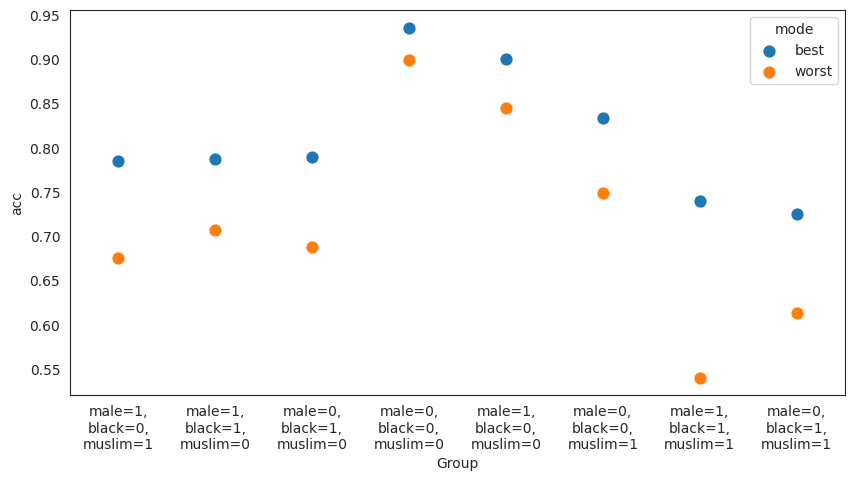

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
def map_group_to_label_name(group, aggregate_group_vars):
    group_name = ""
    for i, group_variable in enumerate(aggregate_group_vars):
        group_title = group_variable.split(':')[1]
        group_name += group_title + "=" + str(group[i]) + ",\n"
    return group_name[:-2]

plt.figure(figsize=(10,5))
alg_choices['group_name'] = alg_choices['aggregate_group'].apply(lambda x: map_group_to_label_name(x, aggregate_group_vars))
sns.pointplot(x='group_name', y='acc', hue='mode', data=alg_choices, join=False)
plt.xlabel("Group")

In [69]:
# If we chose the best model for each example vs if we chose the worst model for each example.
print("Maximum global accuracy: ", np.mean(np.max(accuracy_matrix, axis=0)))    
print("Minimum global accuracy: ", np.mean(np.min(accuracy_matrix, axis=0)))    

Maximum global accuracy:  0.9801767053863748
Minimum global accuracy:  0.7772196558580377
